# General usage

## Input dataset

As a starting point, lets assume we have the following dataset, which was generated based on a harmonic model with some random component:

 * NetCDF format
 * One file per day
 * Each file includes two variables "VAR1" and "VAR2"
 * Half of the files are from the sensor "X1" and the other half from the sensor "X2"
 * "X1" files have the data version "V1", "X2" files have the data version "V5"
 * The CRS of the data is the Equi7Grid projection of the European continent with a sampling of 24km
 * The files are tiled into four adjacent tiles, each with a coverage of 600x600km 

First, we need collect all file paths (around 3000) we want to put into our datacube. How to achieve this is up to you, but you can also use [geopathfinder](https://github.com/TUW-GEO/geopathfinder) to conveniently gather files matching a certain file naming convention. Since our data is stored in one folder and we want to create a datacube of the whole dataset, we can use a simpler approach:

In [1]:
import os
import glob
import pprint
import numpy as np

ds_path = r"D:\data\code\yeoda\2022_08__docs\general_usage"
filepaths = glob.glob(os.path.join(ds_path, "*"))
np.array(filepaths)

C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


array(['D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000101T000000____E042N012T6_EU024KM_V1_X1.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000101T000000____E042N012T6_EU024KM_V5_X2.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000101T000000____E042N018T6_EU024KM_V1_X1.nc',
       ...,
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20001230T000000____E048N012T6_EU024KM_V5_X2.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20001230T000000____E048N018T6_EU024KM_V1_X1.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20001230T000000____E048N018T6_EU024KM_V5_X2.nc'],
      dtype='<U98')

## Datacube generation

As already brought up in the general package description, *yeoda* offers two basic datacube classes, `DataCubeReader` and `DataCubeWriter`. Both inherit from `DataCube`, which consists of the following essential components: 

 * File register: A data frame managing a stack/list of files containing the following columns:
  * "filepath": Full system paths to the files.
  * `stack_dimension` (defaults to "layer_id"): Specifies an ID to which layer a file belongs to, e.g. a layer counter or a timestamp.
  * `tile_dimension` (defaults to "tile_id"): Tile name or ID to which tile a file belongs to.
 * Mosaic geometry: An instance of `MosaicGeometry` (or a child class) managing the spatial properties or representing the actual mosaic/grid of the files  
 * Name of the tile (`tile_dimension`) and stack dimension (`stack_dimension`)
 
Initialising a `DataCubeReader` or `DataCubeWriter` object with a file register is most flexible, but can get tedious if one needs to create a complex data frame by hand. Therefore, both classes offer several class methods to quickly create a datacube instance covering most aspects when working with geospatial data. In the background, a datacube instance keeps a reference to a data format specific reader or writer class defined in [veranda](https://github.com/TUW-GEO/veranda), which actually do all the magic in terms of data IO.    

To be able to start playing around with a datacube object representing our prepared dataset, we can use the `from_filepaths()` method of `DataCubeReader`. This method tries to extract file-specific dimensions based on a certain filenaming convention (defined by the user or already pre-defined in *geopathfinder*)  from the files and generates a file register, on-the-fly. Fortunately, the names of our files follow an existing file naming convention, namely `YeodaFilename`, which represents a generic file naming convention for EO data. If this would not have been the case, one can use *geopathfinder*'s `SmartFilename` class to create a new naming convention from scratch. According to this naming convention we can also define a set of dimension names we are interested in, i.e. the name of the stack/temporal and tile dimension, the variable, sensor, and data version dimension:

In [2]:
from yeoda.datacube import DataCubeReader
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename

dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
dc_reader = DataCubeReader.from_filepaths(filepaths, YeodaFilename, dimensions=dimensions, 
                                          stack_dimension="time", tile_dimension="tile_name")
dc_reader

DataCubeReader -> NetCdfReader(time, MosaicGeometry):

                                               filepath   tile_name var_name  \
0     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
1     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
2     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
3     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
4     D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
...                                                 ...         ...      ...   
2915  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
2916  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
2917  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
2918  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018T6     DVAR   
2919  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018

What we can already directly see from the datacube's print representation is the chosen reader class from *veranda* (i.e. `NetCDFReader`) with its dependent stack dimension ("time") and associated mosaic class (`MosaicGeometry`). Additionally, the file register is shown, which reveals the decoded file naming parts of each file.

## Datacube properties

Our created datacube object has several properties to inspect. For instance, we can take a look at the mosaic to get an impression what spatial extent is covered by the dataset.

<GeoAxesSubplot:>

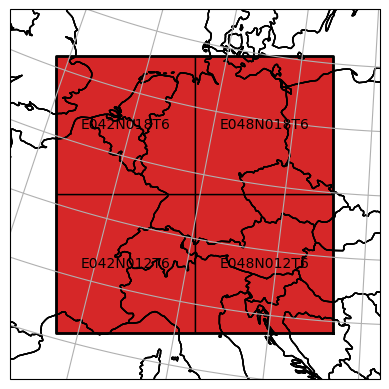

In [3]:
plot_extent = dc_reader.mosaic.outer_extent
extent_bfr = 200e3
plot_extent = [plot_extent[0] - extent_bfr, plot_extent[1] - extent_bfr, 
               plot_extent[2] + extent_bfr, plot_extent[3] + extent_bfr]
dc_reader.mosaic.plot(label_tiles=True, extent=plot_extent)

For further details about the mosaic, please take a look at [geospade's documentation](https://geospade.readthedocs.io/en/latest/notebooks/mosaic_geometry.html).

It is also possible to directly access the file register, 

In [4]:
dc_reader.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
...,...,...,...,...,...,...
2915,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30
2917,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-30
2918,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-30


the number of tiles,

In [5]:
dc_reader.n_tiles

4

the file paths,

In [6]:
np.array(dc_reader.filepaths)

array(['D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000425T000000____E048N012T6_EU024KM_V5_X2.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000704T000000____E048N012T6_EU024KM_V1_X1.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000705T000000____E042N018T6_EU024KM_V5_X2.nc',
       ...,
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000123T000000____E042N018T6_EU024KM_V5_X2.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20000320T000000____E042N012T6_EU024KM_V5_X2.nc',
       'D:\\data\\code\\yeoda\\2022_08__docs\\general_usage\\DVAR_20001122T000000____E042N012T6_EU024KM_V5_X2.nc'],
      dtype='<U98')

the datacube dimensions,

In [7]:
dc_reader.dimensions

['tile_name', 'var_name', 'sensor_field', 'data_version', 'time']

and finally the actual (loaded) xarray data of the files on disk. 

In [8]:
dc_reader.data_view

Since we did not read any data so far, this class attribute is none. The same holds true for a `RasterGeometry` instance associated with loaded data:

In [9]:
dc_reader.data_geom

To access actual coordinates along a certain dimension, a datacube instance supports indexing by means of the dimension name: 

In [10]:
dc_reader['time']

0      2000-01-01
1      2000-01-01
2      2000-01-01
3      2000-01-01
4      2000-01-01
          ...    
2915   2000-12-30
2916   2000-12-30
2917   2000-12-30
2918   2000-12-30
2919   2000-12-30
Name: time, Length: 2920, dtype: datetime64[ns]

In the next section you will learn how to select a subset of a datacube based on the file naming convention of the files. After performing such operations it is always a good idea to check the content of the file register. To quickly check if your selections led to an empty datacube, you can make use of another class property:

In [11]:
dc_reader.is_empty

False

## File-specific selections

The most fundamental function for selecting a subset of the datacube is `select_by_dimension()`. It requires an expression, i.e. a function with one input argument (which will be replaced by a `pd.Series` containing the coordinate values along the specific dimension) linked to formula returning a boolean value if a row/coordinate should be selected or not, and the name of the dimension of interest. 

<div class="alert alert-info">
Most datacube methods have a boolean key-word `inplace` defining if the current datacube instance should be modified or or a new one should be returned. 
</div>

In the example below we are only interested in data from the sensor "X1".

In [12]:
dc_sel = dc_reader.select_by_dimension(lambda s: s == "X1", name="sensor_field")
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
6,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-01-01
8,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-02
...,...,...,...,...,...,...
2910,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-29
2912,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-12-30
2914,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-12-30
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30


More complex expressions are also possible, e.g. when selecting data/files within a specific date range.

In [13]:
import datetime
start_time, end_time = datetime.datetime(2000, 4, 1), datetime.datetime(2000, 5, 1)
dc_sel = dc_reader.select_by_dimension(lambda t: (t >= start_time) & (t <= end_time))
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
728,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-01
729,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-04-01
730,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-04-01
731,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-04-01
732,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-04-01
...,...,...,...,...,...,...
971,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-05-01
972,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-05-01
973,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-05-01
974,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-05-01


Another way to filter certain file paths is `select_files_with_pattern()`, which applies a regex on the file names of the file register.

In [14]:
dc_sel = dc_reader.select_files_with_pattern(".*E042N018T6.*X2.*")
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
11,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-02
19,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-03
27,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-04
35,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-05
...,...,...,...,...,...,...
2883,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-26
2891,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-27
2899,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-28
2907,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-29


In [15]:
dc_sel = dc_reader.select_tiles(["E042N018T6", "E048N012T6"])
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
5,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-01-01
10,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-02
...,...,...,...,...,...,...
2909,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-29
2914,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-12-30
2915,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30


Note that also the mosaic was filtered in the background: 

<GeoAxesSubplot:>

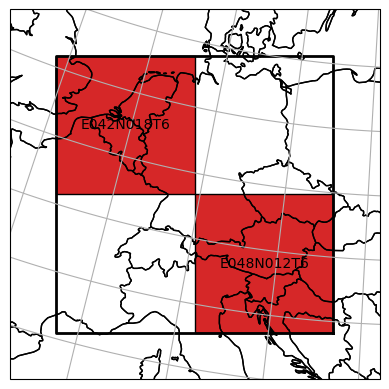

In [16]:
dc_sel.mosaic.plot(label_tiles=True, extent=plot_extent)

## Spatial selections

In the previous section we have seen how we can subset our datacube to select the data we actually want to work with. The last example introduced a first way how to perform a spatial selection of certain tiles, also affecting the properties of the mosaic. 

Yet, one is most often interested in regions being much smaller than a tile or having a different spatial setting, e.g. a certain location, a bounding box, a non-rectangular region delineated by a polygon, or even an area crossing tile boundaries. *yeoda*'s datacube instances allow to perform all of those operations in a fluent manner, without touching any data. The following spatial selection methods expect the actual geometry of selection as positional arguments, and a `SpatialRef` instance as an optional key-word if the CRS of the geometry differs from the mosaic of the datacube.

### Coordinate selection

If one is interested to retrieve a single time-series from the datacube, one can execute the following command.

In [17]:
from geospade.crs import SpatialRef

lat, lon = 48.21, 16.37 # centre of Vienna
sref = SpatialRef(4326)
dc_sel = dc_reader.select_xy(lat, lon, sref=sref)
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
5,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-01-01
12,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-02
13,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-01-02
20,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-03
...,...,...,...,...,...,...
2901,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-28
2908,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-29
2909,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-29
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30


As we can see, the file register only contains a reference to one tile, which covers our point of interest. 

### Bounding box selection

If we are interested in data covering a larger area, we can extend our single-point location to a bounding box.

In [18]:
bbox = [(48.22, 7.1), (49.36, 9,15)] # bounding box around Strasbourg and Karlsruhe
dc_sel = dc_reader.select_bbox(bbox, sref=sref)
dc_sel.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
8,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-02
...,...,...,...,...,...,...
2907,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-29
2912,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-12-30
2913,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-12-30
2914,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-12-30


From the file register we can identify, that the bounding box crosses the border of the two western tiles.

### Pixel window selection

Another possibility to read from a rectangular region of interest is to use the `select_px_window()` method, which accepts the upper-left row and column index as positional arguments and the extent of the pixel window with the keywords `height` and `width`. 

<div class="alert alert-info">
The mosaic will only be sliced if it contains one tile to prevent ambiguities in terms of the definition of the pixel window. Otherwise the original datacube/mosaic will be returned.
</div>

In [19]:
dc_sel = dc_reader.select_tiles(["E042N018T6"])
dc_sel.select_px_window(10, 5, height=6, width=5, inplace=True)
dc_sel.mosaic.tiles[0].shape

(6, 5)

### Polygon selection

As a final and most complex spatial selection example, one can also define a polygon (*shapely* or *ogr* polygon) as a region of interest.

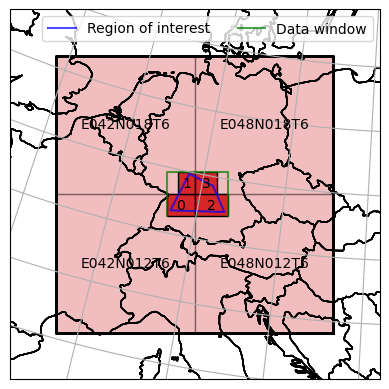

In [20]:
from shapely.geometry import Polygon
polygon = Polygon(((4878945, 1835736), 
                   (4927809, 1723051), 
                   (4694460, 1730031), 
                   (4776232, 1888589))) # given in native units; covers a region in southern Germany intersecting with all tiles
dc_roi = dc_reader.select_polygon(polygon)

ax = dc_reader.mosaic.plot(label_tiles=True, extent=plot_extent, alpha=0.3)
dc_roi.mosaic.plot(label_tiles=True, ax=ax, extent=plot_extent)
ax.plot(*polygon.exterior.coords.xy, color='b', alpha=0.7, label='Region of interest')

# this is how the actual data window would look like, i.e. the spatial coverage of the data read from disk
data_window_xs = dc_roi.mosaic.outer_extent[:1] * 2 + dc_roi.mosaic.outer_extent[2:3] * 2
data_window_ys = dc_roi.mosaic.outer_extent[1],  dc_roi.mosaic.outer_extent[3], dc_roi.mosaic.outer_extent[3], dc_roi.mosaic.outer_extent[1]
ax.plot(data_window_xs, data_window_ys, color='g', alpha=0.7, label='Data window')

ax.legend(ncol=2)

The plot above shows our region of interest defined as a polygon intersecting with all four tiles. The mosaic of `dc_sel` is now decoupled from the naming scheme of the original mosaic and contains four irregularly sliced tiles correspoding to the bounding box of the intersection figure of the polygon and each tile. Later on we will learn how to actually read the data from disk, whose outer pixel extent would be in alignment with the green bounding box.

## Other datacube operations

In addition to the selection methods, a *yeoda* datacube has also a rich set of functions to manage and modify the datacube as needed.   

### Renaming a dimension

If one needs to work with a pre-defined naming convention, but is not happy with the name of a certain dimension/column of the file register, one can use the `rename_dimensions()` function mapping old to new dimension names.

In [21]:
dc_rnmd = dc_reader.rename_dimensions({'sensor_field': 'sensor'})
dc_rnmd.file_register

,filepath,tile_name,var_name,sensor,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
...,...,...,...,...,...,...
2915,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30
2917,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-30
2918,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-30


### Adding a new dimension

Sometimes it can be helpful to add one's own dimension plus coordinate values to a datacube, e.g. file-specific properties like file size, quality flags, etc. 

In [22]:
dim_values = np.random.rand(len(dc_reader))
dc_ext = dc_reader.add_dimension("value", dim_values)
dc_ext.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time,value
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01,0.248208
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01,0.880480
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01,0.505097
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01,0.505629
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01,0.555436
...,...,...,...,...,...,...,...
2915,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30,0.707609
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30,0.960777
2917,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-30,0.428030
2918,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-30,0.666613


### Sorting a dimension

As soon as you read data, each file will be accessed in the order given by file register. If you want to change this, i.e. to sort the files along a specific dimension, then you can use `sort_by_dimension()`.

In [23]:
dc_srtd = dc_ext.sort_by_dimension('value', ascending=True)
dc_srtd.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time,value
1231,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X2,V5,2000-06-02,0.000344
653,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-03-22,0.000518
2289,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-10-13,0.000797
324,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-02-10,0.000839
1724,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-08-03,0.001076
...,...,...,...,...,...,...,...
1639,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X2,V5,2000-07-23,0.998650
292,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-02-06,0.998959
442,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-02-25,0.999363
472,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-02-29,0.999755


### Split up datacube by a dimension

Similar to the file-based selections, one can also use *yeoda*'s split functions to retrieve multiple datacubes from pre-defined coordinate intervals instead of writing multiple select statements. One function to do this is `split_by_dimension`.

In [24]:
dc_sensors = dc_reader.split_by_dimension([lambda s: s == 'X1', lambda s: s == 'X2'], name='sensor_field')
dc_sensors[1]

DataCubeReader -> NetCdfReader(time, MosaicGeometry):

                                               filepath   tile_name var_name  \
1     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
3     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
5     D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
7     D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018T6     DVAR   
9     D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
...                                                 ...         ...      ...   
2911  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018T6     DVAR   
2913  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
2915  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
2917  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
2919  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018

Now we have two datacubes, one for each sensor.

### Split up datacube temporally

Another handy function is `split_by_temporal_freq()`, which splits up the datacube into several smaller ones according to the specified temporal frequency identifier (see [pandas DateOffset objects](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)). 

<div class="alert alert-info">
By default the stack dimension is assumed to be temporal. If not, you need to specify a different dimension with the key-word `name`.
</div>

In [25]:
dc_months = dc_reader.split_by_temporal_freq('M')
dc_months[1]

DataCubeReader -> NetCdfReader(time, MosaicGeometry):

                                              filepath   tile_name var_name  \
248  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
249  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N012T6     DVAR   
250  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
251  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
252  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
..                                                 ...         ...      ...   
475  D:\data\code\yeoda\2022_08__docs\general_usage...  E042N018T6     DVAR   
476  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
477  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N012T6     DVAR   
478  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018T6     DVAR   
479  D:\data\code\yeoda\2022_08__docs\general_usage...  E048N018T6     DVAR 

### Copying a datacube

Sometimes it might be useful to create a (deep-)copy of a datacube object.

In [26]:
dc_cloned = dc_reader.clone()
dc_cloned.select_by_dimension(lambda v: v == 'V1', name='data_version', inplace=True)
print(f"Length of original datacube vs. cloned one: {len(dc_reader)} vs. {len(dc_cloned)}")

Length of original datacube vs. cloned one: 2920 vs. 1460


## Multi-datacube operations

All aforementioned operations have only concerned one datacube object so far, but it is also possible to interact with two or more datacube instances.

### Datacube union

If you have two datacube objects with a different set of dimensions or entries and want to unite (outer join) them, you can call `unite`. The following example demonstrates a union operation of two datacubes having different entries but the same dimensions.

In [27]:
dc_apr = dc_months[3]
dc_sept = dc_months[8]
dc_united = dc_apr.unite(dc_sept)
dc_united.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-04-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-04-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-04-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-04-01
...,...,...,...,...,...,...
475,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-09-30
476,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-09-30
477,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-09-30
478,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-09-30


Another example would be if two datacubes differ in dimensions.

In [28]:
dc_1 = dc_reader.add_dimension('1', [1] * len(dc_reader))
dc_2 = dc_reader.add_dimension('2', [2] * len(dc_reader))
dc_united = dc_1.unite(dc_2)
dc_united.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time,1,2
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01,1.0,NaN
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01,1.0,NaN
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01,1.0,NaN
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01,1.0,NaN
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01,1.0,NaN
...,...,...,...,...,...,...,...,...
5835,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30,NaN,2.0
5836,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30,NaN,2.0
5837,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-30,NaN,2.0
5838,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-30,NaN,2.0


### Datacube intersection

Intersecting two datacubes works similarly, except that this time a inner join operation along the dimensions/columns of the file register takes place. As an optional argument, one can also define a specific dimension to operate the intersection along to perform an intersection also for the entries of the file register. The example below demonstrates an intersection to retrieve the common parts of two datacubes. 

In [29]:
dc_apr_may = dc_months[3].unite(dc_months[4])
dc_may_jun = dc_months[4].unite(dc_months[5])
dc_intersct = dc_apr_may.intersect(dc_may_jun, on_dimension='time')
dc_intersct.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-05-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-05-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-05-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-05-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-05-01
...,...,...,...,...,...,...
243,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-05-31
244,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-05-31
245,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-05-31
246,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-05-31


We can also take the two datacubes from before and intersect them to retrieve the original one.

In [30]:
dc_intersct = dc_1.intersect(dc_2)
dc_intersct.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-01-01
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X2,V5,2000-01-01
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X1,V1,2000-01-01
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-01-01
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-01-01
...,...,...,...,...,...,...
2915,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N018T6,DVAR,X2,V5,2000-12-30
2916,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X1,V1,2000-12-30
2917,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N012T6,DVAR,X2,V5,2000-12-30
2918,D:\data\code\yeoda\2022_08__docs\general_usage...,E048N018T6,DVAR,X1,V1,2000-12-30


### Datacube alignment

As a last multi-datacube operation `align_dimension` allows to reduce or duplicate the number of entries in a datacube with respect to another datacube. However, it is only possible to resolve one-to-many or many-to-one relations with this method. The following example replicates the behaviour of the previously executed intersect operation. First, we need to ensure to only have unique entries along our dimension of interest.

In [31]:
dc_apr_tuni = dc_apr.select_tiles(["E042N012T6"])
_ = dc_apr_tuni.select_by_dimension(lambda s: s == 'X1', name='sensor_field', inplace=True) 

Now we can try to align a large datacube to this smaller datacube along the temporal dimension by taking the many-to-one relation into account.

In [32]:
dc_1_apr = dc_1.align_dimension(dc_apr_tuni, 'time')
dc_1_apr.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time,1
0,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-01,1
1,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-02,1
2,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-03,1
3,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-04,1
4,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-05,1
5,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-06,1
6,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-07,1
7,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-08,1
8,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-09,1
9,D:\data\code\yeoda\2022_08__docs\general_usage...,E042N012T6,DVAR,X1,V1,2000-04-10,1


Another example would be if one wants to duplicate entries in a file register of a datacube so that both have the same length along the specified dimension. To demonstrate this, we can create a fake dataset, containing one file representing one observation of a sensor "X3" in a whole month.

In [33]:
fake_filepaths = [r"D:\data\code\yeoda\2022_08__docs\fake_data\DVAR_20000415T000000____E042N012T6_EU024KM_V1_X3.nc"]
dc_fake = DataCubeReader.from_filepaths(fake_filepaths, YeodaFilename, dimensions=dimensions, 
                                        stack_dimension="time", tile_dimension="tile_name")
dc_fake.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15


By calling `align_dimension` on this datacube with respect to a different datacube along a common dimension, we can duplicate the file register entries so that both datacubes match in length. In this case, we choose the "var_name" dimension as a common dimension, since its already available.  

In [34]:
_ = dc_fake.align_dimension(dc_apr_tuni, "var_name", inplace=True)
dc_fake.file_register

,filepath,tile_name,var_name,sensor_field,data_version,time
0,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
1,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
2,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
3,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
4,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
5,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
6,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
7,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
8,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15
9,D:\data\code\yeoda\2022_08__docs\fake_data\DVA...,E042N012T6,DVAR,X3,V1,2000-04-15


## Reading data

After you have selected the relevant files and spatial extent you want to read from, reading data from disk can be achieved with a single `read()` command. The arguments of the read function dependent on the actual data format of the dataset and are bound to the `read()` functions of the respective readers implemented in *veranda*. Therefore, it is recommended to look up the available arguments in the docstrings of the specific `read()` functions provided in [*veranda*'s documentation ](https://veranda.readthedocs.io/en/latest/index.html).

<div class="alert alert-info">
Note that a `DataCubeReader` or `DataCubeWriter` instance keeps track of open file pointers. To ensure that everything is properly read from or written to disk either use the `.close()` function of a datacube instance or the `with` context when creating an instance.
</div>

As an example, we continue with the datacube generated from the more complex polygon selection, but split it up so that information from each sensor is separately loaded.

In [35]:
dc_roi_x1, dc_roi_x2 = dc_roi.split_by_dimension([lambda s: s == "X1", lambda s: s == "X2"], name='sensor_field')

Now we can read data stemming from sensor "X1" in a very slim manner.

In [36]:
dc_roi_x1.read()

This operation basically creates an internal xarray dataset, which can be viewed via the property `data_view`.

In [37]:
dc_roi_x1.data_view

<xarray.Dataset>
Dimensions:                (time: 365, y: 8, x: 11)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2000-12-30
  * y                      (y) float64 1.896e+06 1.872e+06 ... 1.728e+06
  * x                      (x) float64 4.68e+06 4.704e+06 ... 4.896e+06 4.92e+06
    azimuthal_equidistant  int32 0
Data variables:
    VAR1                   (time, y, x) float64 0.0 0.0 0.0 ... 2.174 2.224 2.21
    VAR2                   (time, y, x) float64 0.0 0.0 0.0 ... 1.778 1.532

Lets look at one layer of the loaded dataset. 

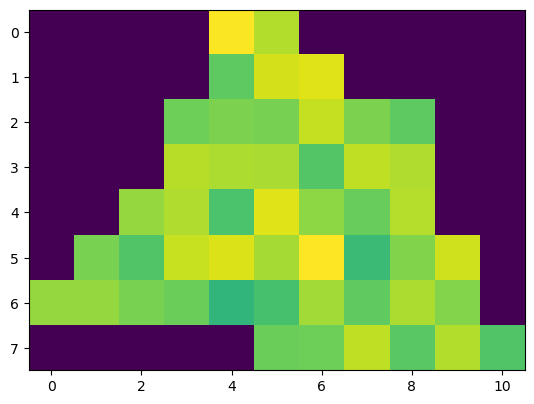

In [38]:
import matplotlib.pyplot as plt

data_layer = dc_roi_x1.data_view.sel({'time': [datetime.date(2000, 4, 1)]})
plt.imshow(data_layer['VAR1'].data[0, ...])

The pixel shape aligns well with the specified polygon, whereas the colour range does not show up as expected. This is because *yeoda* does not automatically set no data values to NaN, since this would require the data to be converted to float, which is not always desired in case of saving memory. In our case the no data value is 0, explaining the behaviour of the colourbar. To convert no data to NaN values, you can simply call `apply_nan()`

In [39]:
dc_roi_x1.apply_nan()

and recreate the plot.

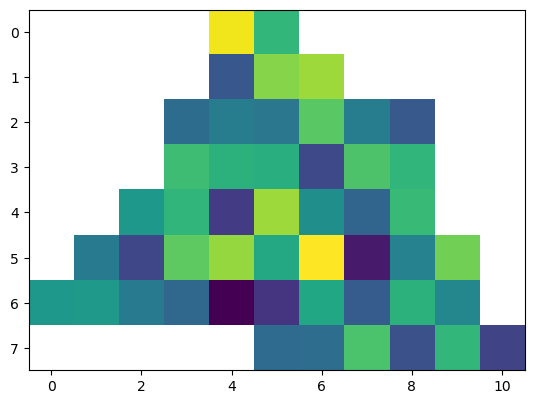

In [40]:
data_layer = dc_roi_x1.data_view.sel({'time': [datetime.date(2000, 4, 1)]})
plt.imshow(data_layer['VAR1'].data[0, ...])

Now every pixel outside the polygon is properly masked.

Another cool feature of *yeoda*'s datacube object is that you can apply select operations in space and along the stack dimension and the data is adapted accordingly. As long as you stay within the boundaries of the loaded dataset, there is no need to re-read data from disk, everything is done in memory. For instance we can load a single time series from both sensor datasets and plot it. 

First, we still need to read the "X2" sensor data.

In [41]:
dc_roi_x2.read()

Then we define our point of interest

In [42]:
lat, lon = 49.16, 9.22 # city of Heilbronn in Germany
sref = SpatialRef(4326)
dc_x1_ts = dc_roi_x1.select_xy(lat, lon, sref=sref)
dc_x2_ts = dc_roi_x2.select_xy(lat, lon, sref=sref)
dc_x1_ts.data_view

<xarray.Dataset>
Dimensions:                (time: 365, y: 1, x: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2000-12-30
  * y                      (y) float64 1.824e+06
  * x                      (x) float64 4.752e+06
    azimuthal_equidistant  int32 0
Data variables:
    VAR1                   (time, y, x) float64 2.189 2.407 ... 2.214 2.052
    VAR2                   (time, y, x) float64 1.681 1.454 1.528 ... 1.32 1.496

and plot our extracted time series

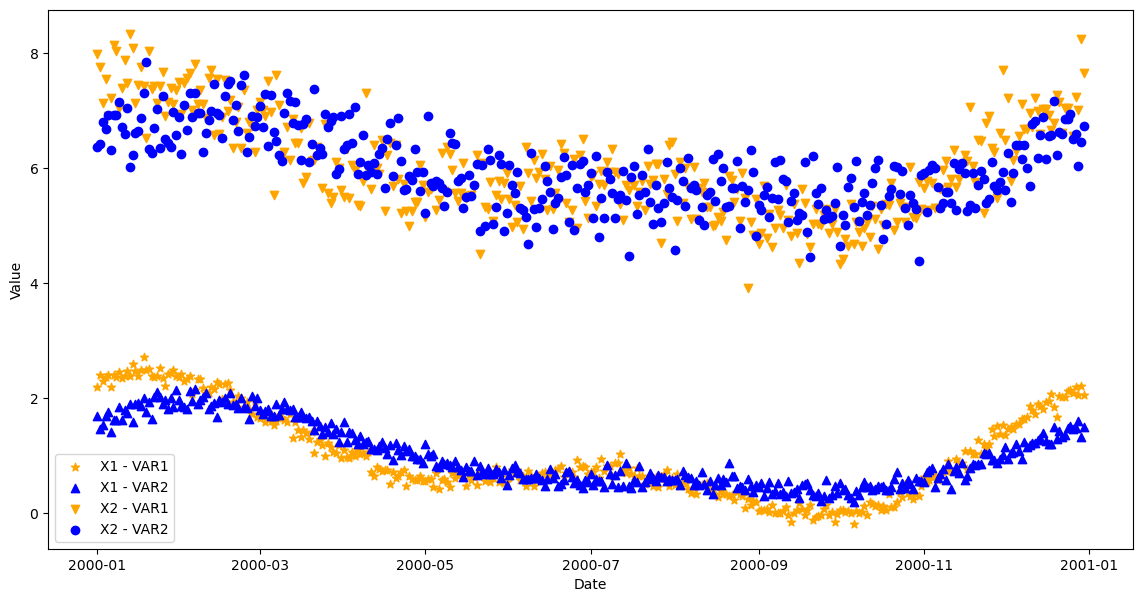

In [43]:
ts = dc_x1_ts.data_view['time'].data
x1_var1_ts = dc_x1_ts.data_view['VAR1'].data.flatten()
x1_var2_ts = dc_x1_ts.data_view['VAR2'].data.flatten()
x2_var1_ts = dc_x2_ts.data_view['VAR1'].data.flatten()
x2_var2_ts = dc_x2_ts.data_view['VAR2'].data.flatten()
plt.figure(figsize=(14, 7))
plt.scatter(ts, x1_var1_ts, label='X1 - VAR1', color='orange', marker='*')
plt.scatter(ts, x1_var2_ts, label='X1 - VAR2', color='b', marker='^')
plt.scatter(ts, x2_var1_ts, label='X2 - VAR1', color='orange', marker='v')
plt.scatter(ts, x2_var2_ts, label='X2 - VAR2', color='b')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend()

## Writing data

*yeoda*'s `DataCubeWriter` class operates in the same manner as `DataCubeReader`, e.g. you can select and filter files, apply spatial subsetting, truncate data etc. Only the start and end point are different - instead of a `from_filepaths()` class method you can now use `from_data()` and instead of the `read()` function, one has the option to either use `write()` or `export()`. Similarly as `from_filepaths()`, `from_data()` automatically creates a file register based on a given file naming convention and some additional key-words assisting in interpreting coordinates of the xarray dataset. The key-word `stack_group` defines the relation between the stack coordinates and a group ID, i.e. in what portions along the stack dimension the data should be written.

<div class="alert alert-warning">
The `stack_group` feature is only meaningful as long as the underlying data format supports to stack multiple files, e.g. NetCDF. 
</div>

If `stack_group` is set, then you can assign new filename attributes to each group ID by using another optional argument `fn_groups_map`, which assigns filename fields to each group ID. In case the tile or stack dimension differ in naming from the chosen filenaming attributes, one can specify the mapping between dimension names and their corresponding filename entry with `fn_map`.

<div class="alert alert-info">
The spatial context is directly derived from the xarray dataset. If the dataset does not have any spatial reference information attached, one can create or use the mosaic of an existing datacube with the same spatial extent.
</div>


### Data export

The first example represents the most simple case, i.e. one has read/created an xarray dataset, which should be written to disk as is. To do so, we first need to initialise a `DataCubeWriter()` instance by using the class method `from_data()`. Here, we can make use of the already available datacube `dc_roi_x1` from the polygon region. We also need to specify the data location where to write the data to, which we choose to be temporary. 

In [44]:
import tempfile

dst_dirpath = tempfile.mkdtemp()

Since we want to write one NetCDF stack to disk, we can create the following stacking arguments, mapping all time stamps of the xarray dataset to a group ID 0:

In [45]:
min_time, max_time = min(dc_roi_x1.data_view['time'].data), max(dc_roi_x1.data_view['time'].data)
stack_groups = {ts: 0 for ts in dc_roi_x1.data_view['time'].data}
fn_groups_map = {0: {'datetime_1': min_time, 'datetime_2': max_time}}

Static file name information can be set with `def_fields`.

In [46]:
def_fields = {'var_name': 'YVAR', 'sensor_field': 'X1'}

Now we have everything ready to initialise our `DataCubeWriter` object

In [47]:
from yeoda.datacube import DataCubeWriter

dc_writer_sngl_stack = DataCubeWriter.from_data(dc_roi_x1.data_view, dst_dirpath,
                                                filename_class=YeodaFilename, ext='.nc', def_fields=def_fields,
                                                stack_dimension='time', tile_dimension='tile_name',
                                                fn_map={'time': 'datetime_1'},
                                                stack_groups=stack_groups,
                                                fn_groups_map=fn_groups_map)
dc_writer_sngl_stack

DataCubeWriter -> NetCdfWriter(time, MosaicGeometry):

                                              filepath       time tile_name
0    C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-01-01         0
1    C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-01-02         0
2    C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-01-03         0
3    C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-01-04         0
4    C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-01-05         0
..                                                 ...        ...       ...
360  C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-12-26         0
361  C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-12-27         0
362  C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-12-28         0
363  C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-12-29         0
364  C:\Users\cnavacch\AppData\Local\Temp\tmpenshg5... 2000-12-30         0

[365 rows x 3 columns]

If we check the file paths, we can see that only one file path is stored in the file register.

In [48]:
dc_writer_sngl_stack.filepaths

['C:\\Users\\cnavacch\\AppData\\Local\\Temp\\tmpenshg5er\\YVAR_20000101T000000_20001230T000000___0___X1.nc']

A (default) mosaic was also generated automatically in compliance with the given data extent.

AttributeError: 'DataCubeWriter' object has no attribute 'plot'

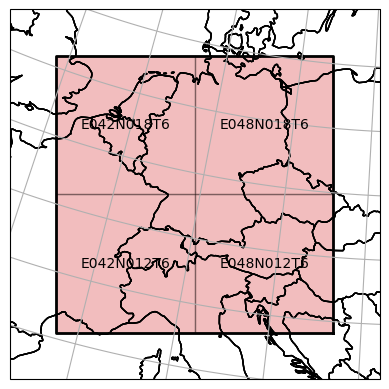

In [49]:
ax = dc_reader.mosaic.parent_root.plot(label_tiles=True, extent=plot_extent, alpha=0.3)
dc_writer_sngl_stack.plot(label_tiles=True, ax=ax, extent=plot_extent)

Finally, one can export all internal data of the datacube to disk by calling `export()`. 

In [ ]:
dc_writer_sngl_stack.export()

As already mentioned before, don't forget to close all file pointers to actually flush the data to disk.

In [ ]:
dc_writer_sngl_stack.close()

Taking a look at the destination, where we wrote our dataset to, reveals that the whole datacube has been written to disk as a single NetCDF file.

In [ ]:
os.listdir(dst_dirpath)

### Data tiling

If one wants to be compliant with the original or even a new tiling scheme, one can initialise a `DataCubeWriter` object with the corresponding mosaic 

In [ ]:
dst_dirpath = tempfile.mkdtemp()
ori_mosaic = dc_reader.mosaic.parent_root
dc_writer_tld_stacks = DataCubeWriter.from_data(dc_roi_x1.data_view, dst_dirpath, mosaic=ori_mosaic,
                                                filename_class=YeodaFilename, ext='.nc', def_fields=def_fields,
                                                stack_dimension='time', tile_dimension='tile_name',
                                                fn_map={'time': 'datetime_1'},
                                                stack_groups=stack_groups,
                                                fn_groups_map=fn_groups_map)

and export the data, but this time with setting the key-word `use_mosaic` to `True`. 

In [ ]:
dc_writer_tld_stacks.export(use_mosaic=True)
dc_writer_tld_stacks.close()

Listing the content of the target directory shows that we have written a single NetCDF stack per tile, only containing the data within our region of interest.

In [ ]:
os.listdir(dst_dirpath)

### Data streaming

Sometimes data is simply too large to be kept in memory or needs to be computed chunk wise. Therefore, a `DataCubeWriter` in *yeoda* provides the function `write()`, which works in the same manner as `export()`, but writes external data to disk, in correspondence with the mosaic of the datacube.

To demonstrate this, we can write the data stored in `dc_roi_x1` to disk, but this time chunk by chunk. First, we reinitialise our datacube object by means of the file register of the existing datacube writer instance after removing the existing file.

In [ ]:
os.remove(dc_writer.filepaths[0])
dc_chunk_writer = DataCubeWriter(dc_writer_sngl_stack.mosaic, file_register=dc_writer_sngl_stack.file_register, 
                                 stack_dimension='time', tile_dimension='tile_name', 
                                 ext='.nc')

Then we extract two chunks from the existing data (first two and last two rows).

In [ ]:
y_coords = dc_roi_x1.data_view['y'].data
chunk_1 = dc_roi_x1.data_view.sel({'y': y_coords[:2]})
chunk_2 = dc_roi_x1.data_view.sel({'y': y_coords[-2:]})

By using `write()`, we are able to write each chunk separately to disk, to the same single NetCDF file. Here, we need to activate `use_mosaic` again, since each chunk should be written inside the single-tile mosaic delineating the data extent we have loaded.

In [ ]:
dc_chunk_writer.write(chunk_1, use_mosaic=True)
dc_chunk_writer.write(chunk_2, use_mosaic=True)
dc_chunk_writer.close()

If we read this NetCDF file again

In [ ]:
dc_reader = DataCubeReader.from_filepaths(dc_chunk_writer.filepaths, YeodaFilename, dimensions=dimensions, 
                                          stack_dimension="layer_id", tile_dimension="tile_name")
dc_reader.read()
dc_reader.apply_nan()

In [ ]:
dc_reader.data_view

and take a look at the same layer as before

In [ ]:
data_layer = dc_reader.data_view.sel({'time': [datetime.date(2000, 4, 1)]})
plt.imshow(data_layer['VAR1'].data[0, ...])

reveals that only the two data chunks have been written to disk.

### Data format conversion

Finally, *yeoda* also allows to switch fluently between different data formats. For instance, we can convert a subset of the NetCDF files representing our original input dataset to multi-band GeoTIFF files. To do so, we reinitialise the datacube reader,

In [ ]:
dc_reader_nc = DataCubeReader.from_filepaths(filepaths, YeodaFilename, dimensions=dimensions, 
                                             stack_dimension="time", tile_dimension="tile_name")

select a sensor,

In [ ]:
dc_reader_nc.select_by_dimension(lambda s: s == "X2", name="sensor_field", inplace=True)

a time frame,

In [ ]:
start_time, end_time = datetime.datetime(2000, 11, 1),  datetime.datetime(2000, 12, 1)
dc_reader_nc.select_by_dimension(lambda t: (t >= start_time) & (t < end_time), name="time", inplace=True)

and a spatial subsetting with a bounding box intersecting on common tile border.

In [ ]:
bbox = [(4649919, 1442955), (5006606, 1748127)]
_ = dc_reader_nc.select_bbox(bbox, inplace=True)

ax = dc_reader_nc.mosaic.parent_root.plot(label_tiles=True, extent=plot_extent, alpha=0.3)
dc_reader_nc.mosaic.plot(label_tiles=True, ax=ax, extent=plot_extent)

After reading the data

In [ ]:
dc_reader_nc.read()
dc_reader_nc.data_view

we can create a new `DataCubeWriter` instance from the data, but this time aiming for generating GeoTIFF files. This instance can now then be used to export all data at once.

In [ ]:
dst_dirpath = tempfile.mkdtemp()
def_fields = {'var_name': 'MVAR', 'sensor_field': 'X2'}
with DataCubeWriter.from_data(dc_reader_nc.data_view, dst_dirpath, filename_class=YeodaFilename, ext='.tif', def_fields=def_fields, 
                              stack_dimension='time', tile_dimension='tile_name',
                              fn_map={'time': 'datetime_1'}) as dc_writer_gt:
    dc_writer_gt.export()

When looking at the location where we have written the data to

In [ ]:
os.listdir(dst_dirpath)

we find all GeoTIFF files in compliance with our performed selection. This new dataset can be swiftly reloaded by defining a reader for GeoTIFF files,

In [ ]:
dc_reader_gt = DataCubeReader.from_filepaths(dc_writer.filepaths, YeodaFilename, dimensions=dimensions, 
                                             stack_dimension="time", tile_dimension="tile_name")

and use it for actually reading data from disk.

<div class="alert alert-info">
When reading GeoTIFF files, one needs to reattach or specify the actual variable names, since this format indexes its layers with band numbers.
</div>

In [ ]:
dc_reader_gt.read(bands=[1, 2], band_names=["VAR1", "VAR2"])
dc_reader_gt.data_view